In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

## Libs

In [21]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model
# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Функции операционной системы
import os

# Работа со временем
import time

# Отрисовка графиков
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os
# Работа со временем
import time
from scipy.ndimage import zoom
import random

from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import mode

# Model 1.1; SU_NET, UNET; IMG_HEIGHT, IMG_WIDTH = 128, 128, geometry - two dimensions

## Servise functions

In [27]:
def load_bscans_and_geometry_two_dim(folder, height, width, channels): 
    bscans_list = []                       # Список для радарограмм
    geometry_list = []
    for bscan in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        if 'bscan_' in bscan:
            bscans_list.append(zoom(np.load(os.path.join(folder, bscan)), (1,0.25)).T)
            # print(folder+'\\'+bscan)
            geom_name=f'geom{bscan[5:-4]}.npy'
            geom_np = np.load(os.path.join(folder, geom_name))

            ### переделываем геометрию, т.к. заданы неверные параметры в датасете
            new_geom = np.zeros((height, width, channels),)
            new_geom[:,:,0] = 1 # Блок епсилон, диэлектрической проницаемости ## to do блять. с геометрией намудрил
            new_geom[3:,:,0] = 6
            new_geom[:,:,1] = 0 # Блок сигмы

            ### правка, добавляем нули сверху
            # new_geom[:geom_np.shape[0],width-geom_np.shape[0]:geom_np.shape[1],:GEOM_CHANNELS] = geom_np
            new_geom[height-geom_np.shape[0]:,width-geom_np.shape[1]:,:GEOM_CHANNELS] = geom_np
            geometry_list.append(new_geom)

    # делаем решейп            
    bscans_array, geometry_array = np.array(bscans_list), np.array(geometry_list)
    
    bscans_array = bscans_array.reshape([bscans_array.shape[0], 
                                   bscans_array.shape[1], 
                                   bscans_array.shape[2], 
                                   1])
    
        # делаем решейп            
    geometry_array = geometry_array.reshape([geometry_array.shape[0], 
                                   geometry_array.shape[1], 
                                   geometry_array.shape[2], 
                                   GEOM_CHANNELS])
    # Возврат массива-результата
    return bscans_array, geometry_array

def visualizate_random_dataset_sample(x, y):
  rand = random.randint(1, len(x)-1)
  bscan = x[rand]
  geom = y[rand]

  fig, ax = plt.subplots(1, 3, figsize = (15,15))
  ax[0].set_title('Радарограмма')
  im0 = ax[0].imshow(bscan[:, :,0])
  divider = make_axes_locatable(ax[0])
  ax_cb0 = divider.append_axes("right", size="5%", pad=0.05)
  fig0 = ax[0].get_figure()
  fig0.add_axes(ax_cb0)
  plt.colorbar(im0, cax=ax_cb0)
  
  ax[1].set_title('Геометрия, ε')
  im1 = ax[1].imshow(geom[:, :,0])
  divider = make_axes_locatable(ax[1])
  ax_cb = divider.append_axes("right", size="5%", pad=0.05)
  fig2 = ax[1].get_figure()
  fig2.add_axes(ax_cb)
  plt.colorbar(im1, cax=ax_cb)

  ax[2].set_title('Геометрия, sigma')
  im2 = ax[2].imshow(geom[:, :, 1])
  divider = make_axes_locatable(ax[2])
  ax_cb2 = divider.append_axes("right", size="5%", pad=0.05)
  fig2 = ax[2].get_figure()
  fig2.add_axes(ax_cb2)
  plt.colorbar(im2, cax=ax_cb2)

  plt.show()

def normalization(dataset):

  max = dataset.max()
  min = dataset.min()
  dataset = (dataset -min)/(max - min)
  def transform(x, max = max, min=min):
    return x*(max-min)+min
  return dataset, transform

def process_images(model,        # обученная модель
                   count = 3     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
  indexes = np.random.randint(0, len(X_test), count)

  bscans = X_test[indexes]
  orig_geom = y_test[indexes]
  # Вычисление предсказания сети для картинок с отобранными индексами
  predict = model.predict(bscans)
  print(predict.min(), predict.max() )

  # Подготовка цветов классов для отрисовки предсказания

  fig, axs = plt.subplots(count, 3, figsize=(25, 15)) 
  for i in range(count):
      # Отображение на графике в первой линии предсказания модели
      axs[0, 0].set_title('Bscan:')
      axs[i, 0].imshow(bscans[i][:,:,0])
      axs[i, 0].axis('off')

      # Отображение на графике во второй линии сегментированного изображения из y_val
      axs[0, 1].set_title('Orig_geom')
      axs[i, 1].imshow(orig_geom[i][:,:,0])
      axs[i ,1].axis('off')

      # Отображение на графике в третьей линии оригинального изображения
      axs[0, 2].set_title('Pred_geom')
      axs[i, 2].imshow(predict[i][:,:,0])
      axs[i ,2].axis('off')

  plt.show()

def show_predict_random_sample(model, X, y,       # обученная модель
                   count = 1,     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
  indexes = np.random.randint(0, len(X_test), count)

  bscans = X[indexes]
  orig_geom = y[indexes]
  # Вычисление предсказания сети для картинок с отобранными индексами
  predict = model.predict(bscans)
  # print(predict.min(), predict.max() )

  # Подготовка цветов классов для отрисовки предсказания

  fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
  for i in range(count):
      axs[0, 0].set_title('Bscan:')
      axs[0, 0].imshow(bscans[i][:,:,0])
      axs[0, 0].axis('off')

      axs[0, 1].set_title('Orig_geom, ε')
      axs[0, 1].imshow(orig_geom[i][:,:,0])
      axs[0 ,1].axis('off')

      axs[0, 2].set_title('Orig_geom, sigma')
      axs[0, 2].imshow(orig_geom[i][:,:,1])
      axs[0 ,2].axis('off')

      axs[1, 0].set_title('Add information:')
      # axs[1, 0].imshow(bscans[i][:,:,0])
      # axs[1, 0].axis('off')

      axs[1, 1].set_title('Pred_geom, ε')
      axs[1, 1].imshow(predict[i][:,:,0])
      axs[1 ,1].axis('off')

      axs[1, 2].set_title('Pred_geom, sigma')
      axs[1, 2].imshow(predict[i][:,:,1])
      axs[1 ,2].axis('off')

  plt.show()

## Giperparams

In [32]:
IMG_HEIGHT, IMG_WIDTH, GEOM_CHANNELS = 128, 128, 2
VAL_SPLIT = 0.1
GEOM_CHANNELS = 2
folder = 'drive/MyDrive/dataset/'
EPOCHS = 50

## Обработка и визуализация датасета

Время загрузки: 105 с.
Размер bscans: (867, 128, 128, 1); размер geoms(867, 128, 128, 2)


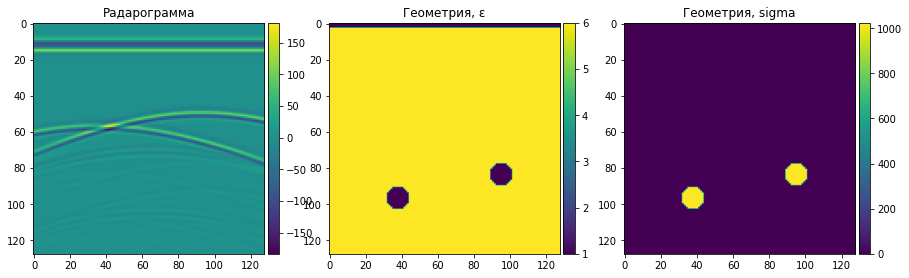

In [7]:
cur_time = time.time()
data_bscans, data_geometry = load_bscans_and_geometry_two_dim(folder, IMG_HEIGHT, IMG_WIDTH, GEOM_CHANNELS)

print(f'Время загрузки: {round(time.time()-cur_time)} с.')
print(f'Размер bscans: {data_bscans.shape}; размер geoms{data_geometry.shape}')

visualizate_random_dataset_sample(data_bscans, data_geometry)

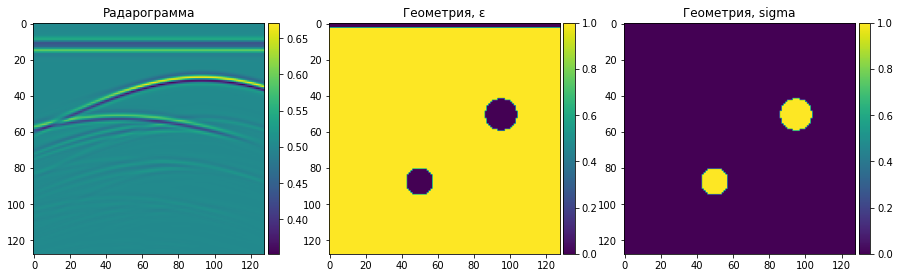

In [11]:
data_bscans_scall, bscans_scaller = normalization(data_bscans)

data_geometry_scall = np.zeros_like(data_geometry)
data_geometry_scall[:,:,:,0], geometry_eps_scaller = normalization(data_geometry[:,:,:,0])
data_geometry_scall[:,:,:,1], geometry_sigma_scaller = normalization(data_geometry[:,:,:,1])

visualizate_random_dataset_sample(data_bscans_scall, data_geometry_scall)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    data_bscans_scall, data_geometry_scall,
    test_size=VAL_SPLIT, 
    random_state=42)

## Model sunet

### Create and fit 

In [33]:
def sunet(input_shape,
          class_count):
  img_input = Input(input_shape)   

  ''' Block 1 '''
  block_1_out = Conv2D(32, (12, 12), padding='same', name='block1_conv1', activation = 'relu')(img_input)
  x = MaxPooling2D()(block_1_out) 

  # ''' Block 2 '''
  block_2_out = Conv2D(64, (5,5), padding='same', name='block2_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_2_out) 

  # ''' Block 3 '''
  block_3_out = Conv2D(128, (3,3), padding='same', name='block3_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_3_out)

  # ''' Block 4 '''
  block_4_out = Conv2D(256, (3,3), padding='same', name='block4_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_4_out)

  # ''' UP 1 '''
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_4_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # x = Conv2D(128, (3,3), padding='same', activation = 'relu')(x)

  # ''' UP 2 '''
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)  

  # ''' UP 3 '''
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])
  x = Conv2D(64, (5, 5), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x) 


  # ''' UP 4 '''
  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(32, (12, 12), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x) 

  x = Conv2D(class_count, (3, 3), padding='same', activation = 'sigmoid')(x)




  model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='mse',
                metrics=['mae'])

  # Возвращаем сформированную модель
  return model

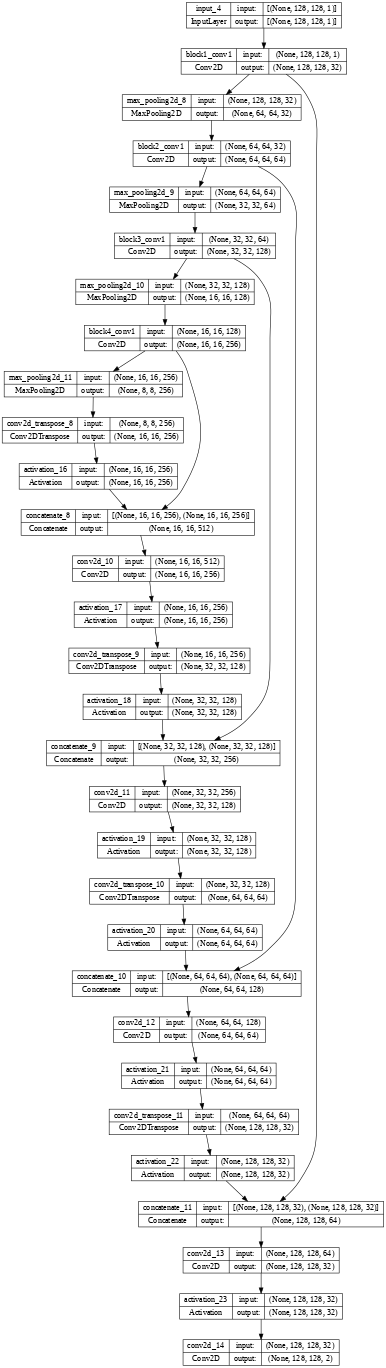

In [34]:
model_sunet = sunet((IMG_WIDTH, IMG_HEIGHT, 1), GEOM_CHANNELS)
utils.plot_model(model_sunet, show_shapes=True, dpi=40)

In [35]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1,
                                      min_lr=0.00001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'sunet_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

history = model_sunet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, model_checkpoint_callback])

25/25 [==============================] - ETA: 0s - loss: 0.0835 - mae: 0.1943 

25/25 [==============================] - 1296s 52s/step - loss: 0.0835 - mae: 0.1943 - val_loss: 0.0355 - val_mae: 0.0410 - lr: 1.0000e-04


### Visualizate

1/1 [==============================] - 0s 412ms/step


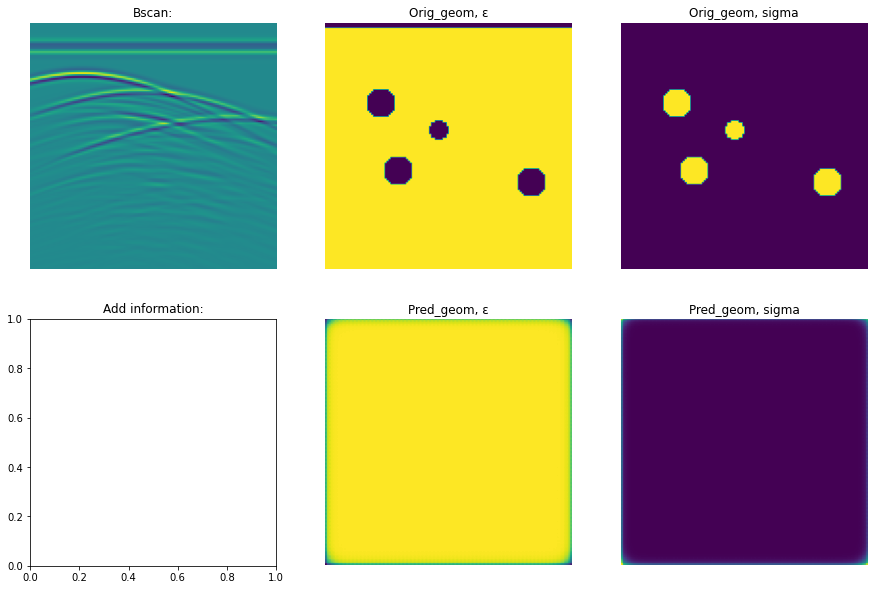

In [36]:
 show_predict_random_sample(model_sunet, X_test, y_test)

## Model unet

### Create and fit 

In [37]:
def unet(input_shape,
          class_count):
  img_input = Input(input_shape)   

  ''' Block 1 '''
  block_1_out = Conv2D(32, (12, 12), padding='same', name='block1_conv1', activation = 'relu')(img_input)
  x = MaxPooling2D()(block_1_out) 

  # ''' Block 2 '''
  block_2_out = Conv2D(64, (5,5), padding='same', name='block2_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_2_out) 

  # ''' Block 3 '''
  block_3_out = Conv2D(128, (3,3), padding='same', name='block3_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_3_out)

  # ''' Block 4 '''
  block_4_out = Conv2D(256, (3,3), padding='same', name='block4_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_4_out)

  # ''' UP 1 '''
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_4_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # x = Conv2D(128, (3,3), padding='same', activation = 'relu')(x)

  # ''' UP 2 '''
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)  

  # ''' UP 3 '''
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])
  x = Conv2D(64, (5, 5), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x) 


  # ''' UP 4 '''
  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(32, (12, 12), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x) 

  x = Conv2D(class_count, (3, 3), padding='same', activation = 'sigmoid')(x)

  model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='mse',
                metrics=['mae'])

  # Возвращаем сформированную модель
  return model

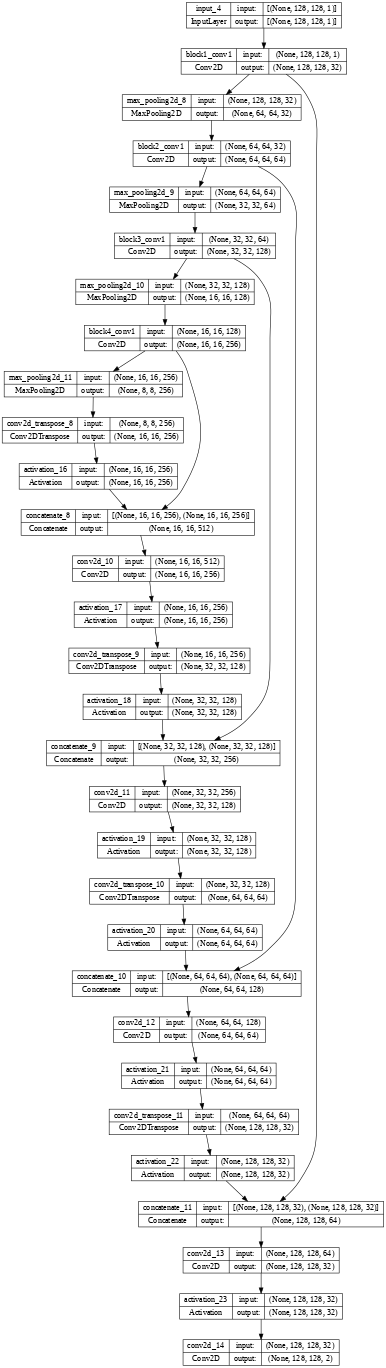

In [38]:
model_unet = sunet((IMG_WIDTH, IMG_HEIGHT, 1), GEOM_CHANNELS)
utils.plot_model(model_sunet, show_shapes=True, dpi=40)

In [40]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1,
                                      min_lr=0.00001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'unet_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

history = model_unet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback])

25/25 [==============================] - ETA: 0s - loss: 0.0925 - mae: 0.2225 

25/25 [==============================] - 1271s 51s/step - loss: 0.0925 - mae: 0.2225 - val_loss: 0.0350 - val_mae: 0.0397 - lr: 1.0000e-04


### Visualizate

1/1 [==============================] - 0s 441ms/step


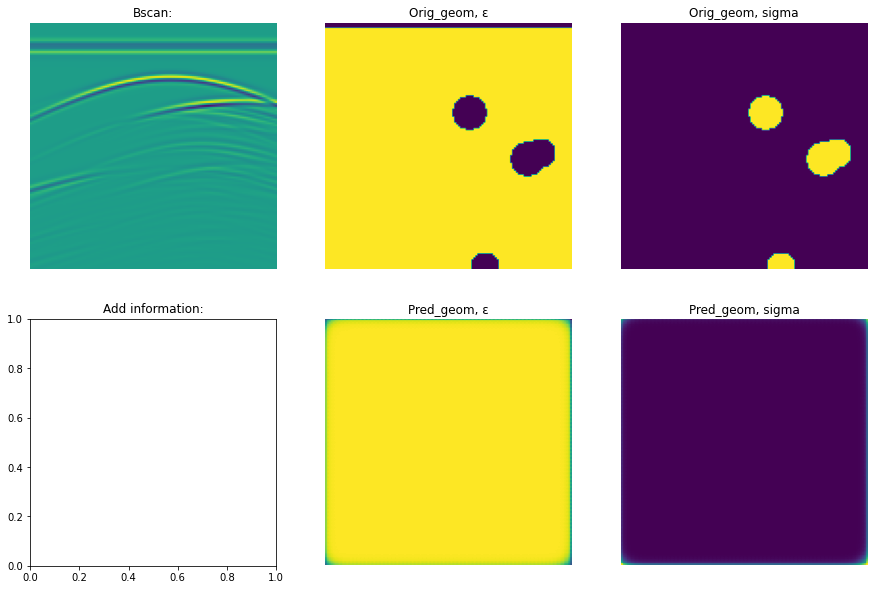

In [41]:
 show_predict_random_sample(model_unet, X_test, y_test)

## Model AE

### Create and fit 

In [ ]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape, geom_channels):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(geom_channels, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse',
                metrics = 'mae')

  return model

In [ ]:
model_ae = create_base_ae((IMG_WIDTH, IMG_HEIGHT, 1), GEOM_CHANNELS)
utils.plot_model(model_ae, show_shapes=True, dpi=40)

In [44]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1,
                                      min_lr=0.00001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'base_ae_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

history = model_ae.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback])

 7/25 [=======>......................] - ETA: 5:34 - loss: 1.3535 - mae: 0.9002

KeyboardInterrupt: ignored

### Visualizate

In [ ]:
 show_predict_random_sample(model_ae, X_test, y_test)

## Model sequential_segmentation_net

In [46]:
def sequential_segmentation_net(class_count,  # количество классов
                                input_shape   # форма входного изображения
                                ):

    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)   

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv4')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)     

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv5')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)           
       
    x = Conv2D(class_count, (3, 3), activation='sigmoid', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'],
                  )
    
    # Возвращаем сформированную модель
    return model 

# Создание модели и вывод сводки по архитектуре

model_seq = sequential_segmentation_net(GEOM_CHANNELS ,
                                       (IMG_WIDTH, IMG_HEIGHT, 1))

# model_seq.summary()



In [47]:
# Обучение модели

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1,
                                      min_lr=0.00001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'seg_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

history = model_seq.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback])

25/25 [==============================] - ETA: 0s - loss: 0.1228 - mae: 0.3236 

25/25 [==============================] - 273s 11s/step - loss: 0.1228 - mae: 0.3236 - val_loss: 0.2243 - val_mae: 0.4733 - lr: 0.0010


### Visualizate

1/1 [==============================] - 0s 198ms/step


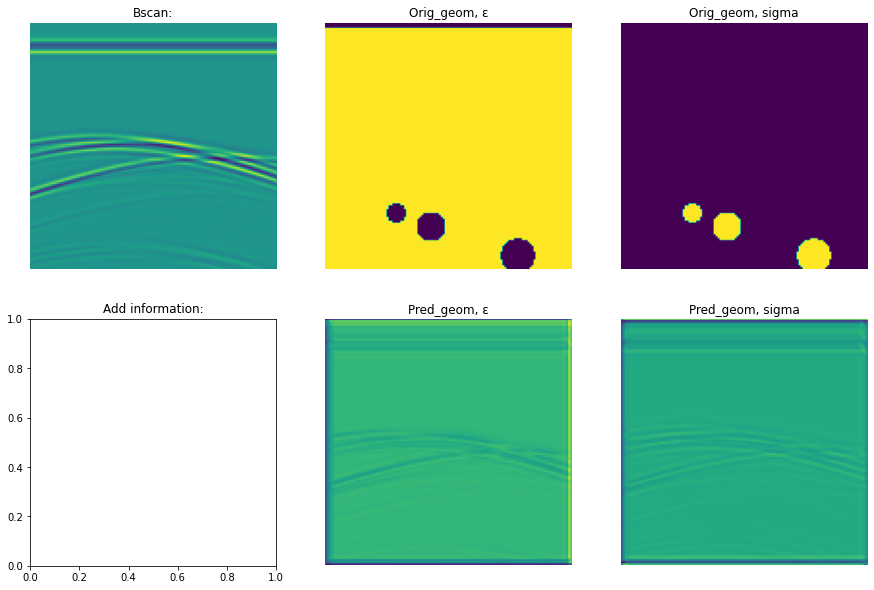

In [48]:
 show_predict_random_sample(model_seq, X_test, y_test)

## Расширенная архитектура U-net


In [51]:
def masked_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):
  
    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)          # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out)                                             # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                             # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                             # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                             # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                                   # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                         # Объединяем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                         # Объединяем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                         # Объединяем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)          # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                         # Объединяем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='sigmoid', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'
    
    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # Возвращаем сформированную модель
    return model

In [ ]:
model_masked_unet = masked_unet(GEOM_CHANNELS, (IMG_WIDTH, IMG_HEIGHT, 1), )
utils.plot_model(model_masked_unet, show_shapes=True, dpi=40)

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1,
                                      min_lr=0.00001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'base_masked_unet_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

history = model_masked_unet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback])

### Visualizate

In [ ]:
 show_predict_random_sample(model_masked_unet, X_test, y_test)